In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

import glob
import json

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model, layers, Input
from tensorflow.keras.layers import Dense, Input, Concatenate, Activation, InputLayer, Conv1D, MaxPooling1D
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

from sklearn import svm
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
# Path to files: ~/ikt459/mmWaveRadarCube/mmWave/<material>.mat
file_paths = sorted(glob.glob("mmWave/*.mat"))

X_re_list = []
Y_re_list = []

X_im_list = []
Y_im_list = []

X_reim_list = []
Y_reim_list = []

X_reimabs_list = []
Y_reimabs_list = []

X_reimabsphase_list = []
Y_reimabsphase_list = []

samples = (100, 500, 1000)
count = 2

for label, file in enumerate(file_paths):
    data = h5py.File(file, 'r')

    X = np.transpose(np.array(data["data"])) # Shape: (num_samples, 256)
    num_samples = X.shape[0] # 524288
    #X = X[:samples[count], :] # First N samples of class dataset
    indices = np.random.choice(num_samples-1000, size=samples[count], replace=False)
    X = X[indices] # Random N samples of class dataset (but not the last 1000)

    # Convert X to array containing complex numbers
    X = np.array([x["real"] + 1j * x["imag"] for x in X]).astype(np.cdouble) # Shape: (num_samples, 256)

    Y = np.full((X.shape[0],), label, dtype=np.int32)

    real = X.real.astype(np.float32) # Shape: (num_samples, 256)
    imag = X.imag.astype(np.float32) # Shape: (num_samples, 256)
    absolute = np.abs(X).astype(np.float32) # Shape: (num_samples, 256)
    phase = np.angle(X).astype(np.float32) # Shape: (num_samples, 256)

    # --- Real ---
    X_re_list.append(real)
    Y_re_list.append(np.full((real.shape[0],), label, dtype=np.int32))

    # --- Imaginary ---
    X_im_list.append(imag)
    Y_im_list.append(np.full((imag.shape[0],), label, dtype=np.int32))

    # --- Real + Imaginary ---
    real_imag = np.stack([real, imag], axis=-1) # Shape: (num_samples, 256, 2)
    X_reim_list.append(real_imag)
    Y_reim_list.append(np.full((real_imag.shape[0],), label, dtype=np.int32))

    # --- Real + Imaginary + Absolute ---
    real_imag_abs = np.stack([real, imag, absolute], axis=-1) # Shape: (num_samples, 256, 3)
    X_reimabs_list.append(real_imag_abs)
    Y_reimabs_list.append(np.full((real_imag_abs.shape[0],), label, dtype=np.int32))

    # --- Real + Imaginary + Absolute + Phase ---
    real_imag_abs_phase = np.stack([real, imag, absolute, phase], axis=-1) # Shape: (num_samples, 256, 4)
    X_reimabsphase_list.append(real_imag_abs_phase)
    Y_reimabsphase_list.append(np.full((real_imag_abs_phase.shape[0],), label, dtype=np.int32))

    print(f"Finished for label {label}")

# --- Real ---
X_re_all = np.concatenate(X_re_list, axis=0)
X_re_all = np.expand_dims(X_re_all, axis=-1)
Y_re_all = np.concatenate(Y_re_list, axis=0)

# --- Imaginary ---
X_im_all = np.concatenate(X_im_list, axis=0)
X_im_all = np.expand_dims(X_im_all, axis=-1)
Y_im_all = np.concatenate(Y_im_list, axis=0)

# --- Real + Imaginary ---
X_reim_all = np.concatenate(X_reim_list, axis=0)
Y_reim_all = np.concatenate(Y_reim_list, axis=0)

# --- Real + Imaginary + Absolute ---
X_reimabs_all = np.concatenate(X_reimabs_list, axis=0)
Y_reimabs_all = np.concatenate(Y_reimabs_list, axis=0)

# --- Real + Imaginary + Absolute + Phase ---
X_reimabsphase_all = np.concatenate(X_reimabsphase_list, axis=0)
Y_reimabsphase_all = np.concatenate(Y_reimabsphase_list, axis=0)

print(f"\nFinal data set shapes:")
print(f"Real: {X_re_all.shape}")
print(f"Imaginary: {X_im_all.shape}")
print(f"Real + Imaginary: {X_reim_all.shape}")
print(f"Real + Imaginary + Absolute: {X_reimabs_all.shape}")
print(f"Real + Imaginary + Absolute + Phase: {X_reimabsphase_all.shape}")

print(f"\nFinal labels shapes:")
print(f"Real: {Y_re_all.shape}")
print(f"Imaginary: {Y_im_all.shape}")
print(f"Real + Imaginary: {Y_reim_all.shape}")
print(f"Real + Imaginary + Absolute: {Y_reimabs_all.shape}")
print(f"Real + Imaginary + Absolute + Phase: {Y_reimabsphase_all.shape}")

print(f"\nUnique classes:") # Should be [0 1 ... 9] (10 classes)
print(f"Real: {np.unique(Y_re_all)}")
print(f"Imaginary: {np.unique(Y_im_all)}")
print(f"Real + Imaginary: {np.unique(Y_reim_all)}")
print(f"Real + Imaginary + Absolute: {np.unique(Y_reimabs_all)}")
print(f"Real + Imaginary + Absolute + Phase: {np.unique(Y_reimabsphase_all)}")

Finished for label 0
Finished for label 1
Finished for label 2
Finished for label 3
Finished for label 4
Finished for label 5
Finished for label 6
Finished for label 7
Finished for label 8
Finished for label 9

Final data set shapes:
Real: (10000, 256, 1)
Imaginary: (10000, 256, 1)
Real + Imaginary: (10000, 256, 2)
Real + Imaginary + Absolute: (10000, 256, 3)
Real + Imaginary + Absolute + Phase: (10000, 256, 4)

Final labels shapes:
Real: (10000,)
Imaginary: (10000,)
Real + Imaginary: (10000,)
Real + Imaginary + Absolute: (10000,)
Real + Imaginary + Absolute + Phase: (10000,)

Unique classes:
Real: [0 1 2 3 4 5 6 7 8 9]
Imaginary: [0 1 2 3 4 5 6 7 8 9]
Real + Imaginary: [0 1 2 3 4 5 6 7 8 9]
Real + Imaginary + Absolute: [0 1 2 3 4 5 6 7 8 9]
Real + Imaginary + Absolute + Phase: [0 1 2 3 4 5 6 7 8 9]


In [3]:
# A given random state ensures reproducibility
# Test set is 10%, the other 90% is for training

# --- Real ---
X_all = X_re_all
Y_all = Y_re_all

indices = np.arange(len(X_all))
train_idx, test_idx = train_test_split(indices, test_size=0.1, stratify=Y_all)

X_train = X_all[train_idx]
X_test = X_all[test_idx]
Y_train = Y_all[train_idx]
Y_test = Y_all[test_idx]

# Normalize train and test data
max_real = np.max(np.abs(X_train))

# Apply train stats to train and test
X_train_real = X_train / max_real
X_test_real = X_test / max_real
X_re_train_split = X_train_real
X_re_test_split = X_test_real

# Same for Y
Y_re_train = Y_train
Y_re_test = Y_test

# Prints
print("Real:")
print("Train set shape:", X_train.shape) # Shape: (total_samples * 0.9, 256, 1)
print("Test set shape:", X_test.shape) # Shape: (total_samples * 0.1, 256, 1)
print("Train class distribution:", np.bincount(Y_train))
print("Test class distribution:", np.bincount(Y_test))


# --- Imaginary ---
X_all = X_im_all
Y_all = Y_im_all

indices = np.arange(len(X_all))
train_idx, test_idx = train_test_split(indices, test_size=0.1, stratify=Y_all)

X_train = X_all[train_idx]
X_test = X_all[test_idx]
Y_train = Y_all[train_idx]
Y_test = Y_all[test_idx]

# Normalize train and test data
max_imag = np.max(np.abs(X_train))

# Apply train stats to train and test
X_train_imag = X_train / max_imag
X_test_imag = X_test / max_imag
X_im_train_split = X_train_imag
X_im_test_split = X_test_imag

# Same for Y
Y_im_train = Y_train
Y_im_test = Y_test

# Prints
print("\nImaginary:")
print("Train set shape:", X_train.shape) # Shape: (total_samples * 0.9, 256, 1)
print("Test set shape:", X_test.shape) # Shape: (total_samples * 0.1, 256, 1)
print("Train class distribution:", np.bincount(Y_train))
print("Test class distribution:", np.bincount(Y_test))

# --- Real + Imaginary ---
X_all = X_reim_all
Y_all = Y_reim_all

indices = np.arange(len(X_all))
train_idx, test_idx = train_test_split(indices, test_size=0.1, stratify=Y_all)

X_train = X_all[train_idx]
X_test = X_all[test_idx]
Y_train = Y_all[train_idx]
Y_test = Y_all[test_idx]

# Normalize train and test data
train_real = X_train[:, :, 0].reshape(-1, 256, 1)
train_imag = X_train[:, :, 1].reshape(-1, 256, 1)

max_real = np.max(np.abs(train_real))
max_imag = np.max(np.abs(train_imag))

# Apply train stats to train and test
X_train_real = train_real / max_real
X_train_imag = train_imag / max_imag
X_reim_train_split = [X_train_real, X_train_imag]

X_test_real = X_test[:, :, 0].reshape(-1, 256, 1) / max_real
X_test_imag = X_test[:, :, 1].reshape(-1, 256, 1) / max_imag
X_reim_test_split = [X_test_real, X_test_imag]

# Same for Y
Y_reim_train = Y_train
Y_reim_test = Y_test

# Prints
print("\nReal + Imaginary:")
print("Train set shape:", X_train.shape) # Shape: (total_samples * 0.9, 256, 2)
print("Test set shape:", X_test.shape) # Shape: (total_samples * 0.1, 256, 2)
print("Train class distribution:", np.bincount(Y_train))
print("Test class distribution:", np.bincount(Y_test))


# Real + Imaginary + Absolute
X_all = X_reimabs_all
Y_all = Y_reimabs_all

indices = np.arange(len(X_all))
train_idx, test_idx = train_test_split(indices, test_size=0.1, stratify=Y_all)

X_train = X_all[train_idx]
X_test = X_all[test_idx]
Y_train = Y_all[train_idx]
Y_test = Y_all[test_idx]

# Normalize train and test data
train_real = X_train[:, :, 0].reshape(-1, 256, 1)
train_imag = X_train[:, :, 1].reshape(-1, 256, 1)
train_abs = X_train[:, :, 2].reshape(-1, 256, 1)

max_real = np.max(np.abs(train_real))
max_imag = np.max(np.abs(train_imag))
max_abs = np.max(np.abs(train_abs))

# Apply train stats to train and test
X_train_real = train_real / max_real
X_train_imag = train_imag / max_imag
X_train_abs = train_abs / max_abs
X_reimabs_train_split = [X_train_real, X_train_imag, X_train_abs]

X_test_real = X_test[:, :, 0].reshape(-1, 256, 1) / max_real
X_test_imag = X_test[:, :, 1].reshape(-1, 256, 1) / max_imag
X_test_abs = X_test[:, :, 2].reshape(-1, 256, 1) / max_abs
X_reimabs_test_split = [X_test_real, X_test_imag, X_test_abs]

# Same for Y
Y_reimabs_train = Y_train
Y_reimabs_test = Y_test

# Prints
print("\nReal + Imaginary + Absolute:")
print("Train set shape:", X_train.shape) # Shape: (total_samples * 0.9, 256, 3)
print("Test set shape:", X_test.shape) # Shape: (total_samples * 0.1, 256, 3)
print("Train class distribution:", np.bincount(Y_train))
print("Test class distribution:", np.bincount(Y_test))


# Real + Imaginary + Absolute + Phase
X_all = X_reimabsphase_all
Y_all = Y_reimabsphase_all

indices = np.arange(len(X_all))
train_idx, test_idx = train_test_split(indices, test_size=0.1, stratify=Y_all)

X_train = X_all[train_idx]
X_test = X_all[test_idx]
Y_train = Y_all[train_idx]
Y_test = Y_all[test_idx]

# Normalize train and test data
train_real = X_train[:, :, 0].reshape(-1, 256, 1)
train_imag = X_train[:, :, 1].reshape(-1, 256, 1)
train_abs = X_train[:, :, 2].reshape(-1, 256, 1)
train_phase = X_train[:, :, 3].reshape(-1, 256, 1)

max_real = np.max(np.abs(train_real))
max_imag = np.max(np.abs(train_imag))
max_abs = np.max(np.abs(train_abs))
max_phase = np.max(np.abs(train_phase))

# Apply train stats to train and test
X_train_real = train_real / max_real
X_train_imag = train_imag / max_imag
X_train_abs = train_abs / max_abs
X_train_phase = train_phase / max_phase
X_reimabsphase_train_split = [X_train_real, X_train_imag, X_train_abs, X_train_phase]

X_test_real = X_test[:, :, 0].reshape(-1, 256, 1) / max_real
X_test_imag = X_test[:, :, 1].reshape(-1, 256, 1) / max_imag
X_test_abs = X_test[:, :, 2].reshape(-1, 256, 1) / max_abs
X_test_phase = X_test[:, :, 3].reshape(-1, 256, 1) / max_phase
X_reimabsphase_test_split = [X_test_real, X_test_imag, X_test_abs, X_test_phase]

# Same for Y
Y_reimabsphase_train = Y_train
Y_reimabsphase_test = Y_test

# Prints
print("\nReal + Imaginary + Absolute + Phase:")
print("Train set shape:", X_train.shape) # Shape: (total_samples * 0.9, 256, 4)
print("Test set shape:", X_test.shape) # Shape: (total_samples * 0.1, 256, 4)
print("Train class distribution:", np.bincount(Y_train))
print("Test class distribution:", np.bincount(Y_test))

Real:
Train set shape: (9000, 256, 1)
Test set shape: (1000, 256, 1)
Train class distribution: [900 900 900 900 900 900 900 900 900 900]
Test class distribution: [100 100 100 100 100 100 100 100 100 100]

Imaginary:
Train set shape: (9000, 256, 1)
Test set shape: (1000, 256, 1)
Train class distribution: [900 900 900 900 900 900 900 900 900 900]
Test class distribution: [100 100 100 100 100 100 100 100 100 100]

Real + Imaginary:
Train set shape: (9000, 256, 2)
Test set shape: (1000, 256, 2)
Train class distribution: [900 900 900 900 900 900 900 900 900 900]
Test class distribution: [100 100 100 100 100 100 100 100 100 100]

Real + Imaginary + Absolute:
Train set shape: (9000, 256, 3)
Test set shape: (1000, 256, 3)
Train class distribution: [900 900 900 900 900 900 900 900 900 900]
Test class distribution: [100 100 100 100 100 100 100 100 100 100]

Real + Imaginary + Absolute + Phase:
Train set shape: (9000, 256, 4)
Test set shape: (1000, 256, 4)
Train class distribution: [900 900 900 9

In [4]:
# Define the model
def cnn_model(input_shape=(256, 1), num_channels=2, num_classes=10):
    input_layers = []
    flat_layers = []
    ksize = 3

    for i in range(num_channels):
        inp = Input(shape=input_shape)
        x = layers.Conv1D(64, kernel_size=ksize, padding='same')(inp)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv1D(128, kernel_size=ksize, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.GlobalMaxPooling1D()(x)

        input_layers.append(inp)
        flat_layers.append(x)

    # Merged layer
    if len(flat_layers) > 1:
        merged = layers.Concatenate()(flat_layers)
    else:
        merged = flat_layers[0]

    y = layers.Dropout(0.3)(merged)
    y = layers.Dense(128, activation='relu')(y)
    y = layers.Dropout(0.3)(y)
    output = layers.Dense(num_classes, activation='softmax')(y)

    model = Model(inputs=input_layers, outputs=output)

    model.compile(
        loss=tf.keras.losses.sparse_categorical_crossentropy,
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=['accuracy'],
    )

    model.summary()
    plot_model(model, show_shapes=True, to_file="1D_CNN_model.png")
    return model

In [5]:
# Create the models for combos

real_model = cnn_model(input_shape=(256, 1), num_channels=1, num_classes=10)
imag_model = cnn_model(input_shape=(256, 1), num_channels=1, num_classes=10)
reim_model = cnn_model(input_shape=(256, 1), num_channels=2, num_classes=10)
reimabs_model = cnn_model(input_shape=(256, 1), num_channels=3, num_classes=10)
reimabsphase_model = cnn_model(input_shape=(256, 1), num_channels=4, num_classes=10)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 256, 64)           256       
                                                                 
 batch_normalization (Batch  (None, 256, 64)           256       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 256, 64)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 256, 128)          24704     
                                                                 
 batch_normalization_1 (Bat  (None, 256, 128)          512       
 chNormalization)                                            

In [6]:
# Training through running the model with the data
print("--- REAL MODEL EPOCHS ---")
real_history = real_model.fit(X_re_train_split, Y_re_train, batch_size=64, epochs=30, shuffle=True, validation_split=0.10)

print("\n--- IMAGINARY MODEL EPOCHS ---")
imag_history = imag_model.fit(X_im_train_split, Y_im_train, batch_size=64, epochs=30, shuffle=True, validation_split=0.10)

print("\n--- REAL + IMAGINARY MODEL EPOCHS ---")
reim_history = reim_model.fit(X_reim_train_split, Y_reim_train, batch_size=64, epochs=30, shuffle=True, validation_split=0.10)

print("\n--- REAL + IMAGINARY + ABSOLUTE MODEL EPOCHS ---")
reimabs_history = reimabs_model.fit(X_reimabs_train_split, Y_reimabs_train, batch_size=64, epochs=30, shuffle=True, validation_split=0.10)

print("\n--- REAL + IMAGINARY + ABSOLUTE + PHASE MODEL EPOCHS ---")
reimabsphase_history = reimabsphase_model.fit(X_reimabsphase_train_split, Y_reimabsphase_train, batch_size=64, epochs=30, shuffle=True, validation_split=0.10)

--- REAL MODEL EPOCHS ---
Epoch 1/30
127/127 [==============================] - 6s 37ms/step - loss: 2.0987 - accuracy: 0.3180 - val_loss: 2.5505 - val_accuracy: 0.1044
Epoch 2/30
127/127 [==============================] - 4s 35ms/step - loss: 1.0264 - accuracy: 0.6206 - val_loss: 5.0261 - val_accuracy: 0.1044
Epoch 3/30
127/127 [==============================] - 4s 34ms/step - loss: 0.6104 - accuracy: 0.7701 - val_loss: 7.2605 - val_accuracy: 0.1044
Epoch 4/30
127/127 [==============================] - 4s 35ms/step - loss: 0.4534 - accuracy: 0.8331 - val_loss: 3.1781 - val_accuracy: 0.1522
Epoch 5/30
127/127 [==============================] - 4s 35ms/step - loss: 0.3362 - accuracy: 0.8748 - val_loss: 0.1982 - val_accuracy: 0.9589
Epoch 6/30
127/127 [==============================] - 4s 35ms/step - loss: 0.2930 - accuracy: 0.8942 - val_loss: 0.0630 - val_accuracy: 0.9944
Epoch 7/30
127/127 [==============================] - 4s 35ms/step - loss: 0.2525 - accuracy: 0.9112 - val_loss: 0.0

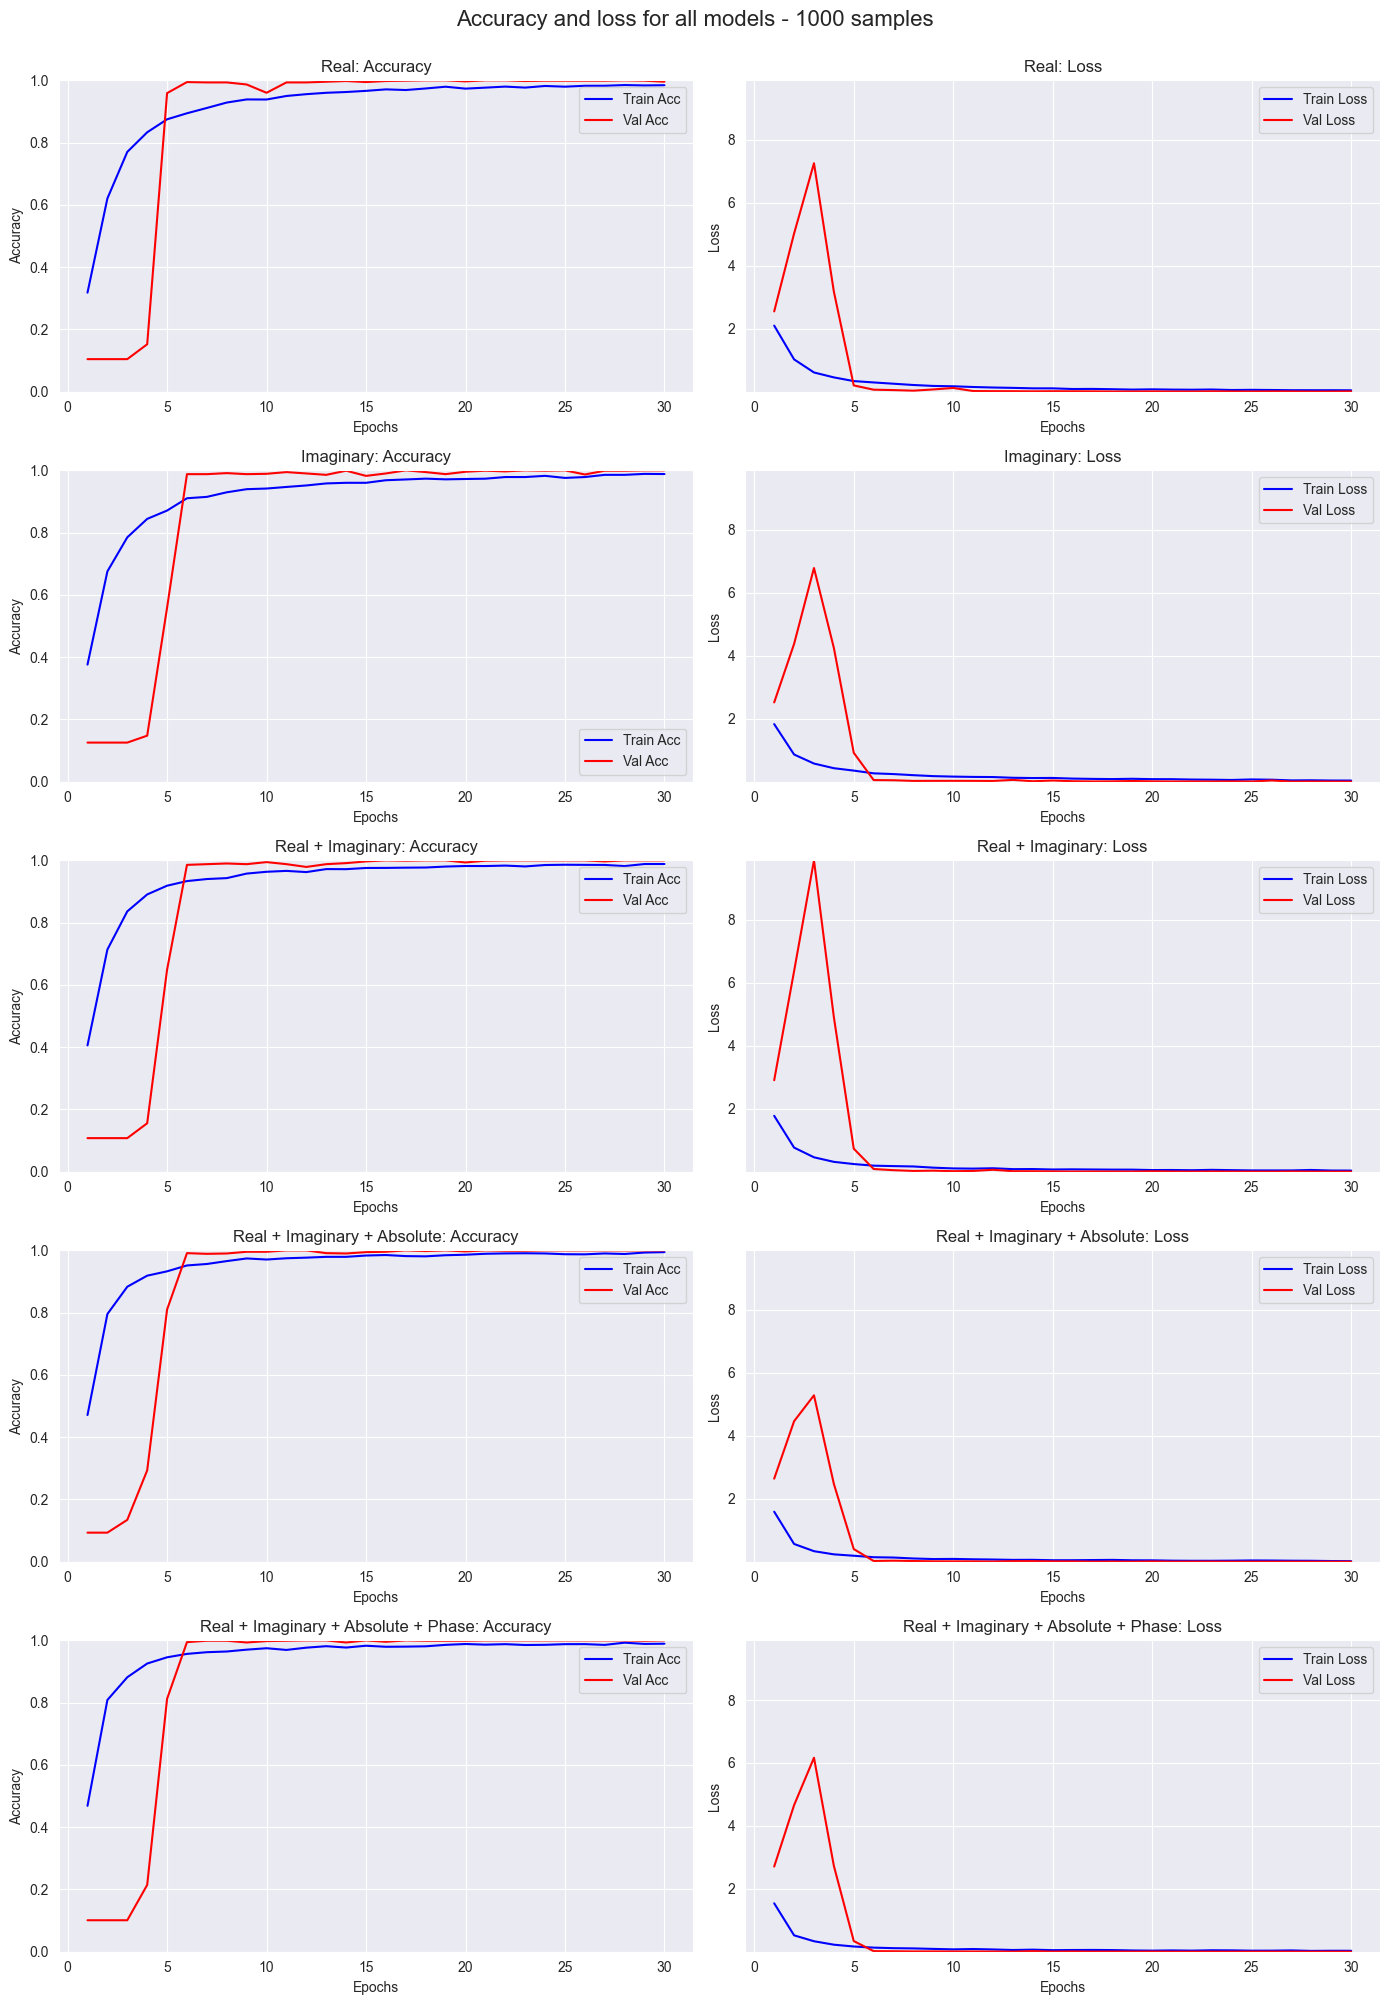

In [7]:
# List of histories, one per model
histories = [real_history, imag_history, reim_history, reimabs_history, reimabsphase_history]
titles = ["Real", "Imaginary", "Real + Imaginary", "Real + Imaginary + Absolute", "Real + Imaginary + Absolute + Phase"]

# Compute global y-axis limit for loss
all_loss = []

for h in histories:
    all_loss.extend(h.history["loss"] + h.history["val_loss"])

acc_ylim = (0, 1)
loss_ylim = (min(all_loss), max(all_loss))

# Plot
plt.figure(figsize=(14, 20))

for i, history in enumerate(histories):
    train_acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(train_acc) + 1)

    # Accuracy subplot
    plt.subplot(len(histories), 2, i * 2 + 1)
    plt.plot(epochs, train_acc, 'b-', label="Train Acc")
    plt.plot(epochs, val_acc, 'r-', label="Val Acc")
    plt.title(f"{titles[i]}: Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.ylim(acc_ylim)
    plt.legend()
    plt.grid(True)

    # Loss subplot
    plt.subplot(len(histories), 2, i * 2 + 2)
    plt.plot(epochs, train_loss, 'b-', label="Train Loss")
    plt.plot(epochs, val_loss, 'r-', label="Val Loss")
    plt.title(f"{titles[i]}: Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.ylim(loss_ylim)
    plt.legend()
    plt.grid(True)

plt.suptitle(f"Accuracy and loss for all models - {samples[count]} samples", fontsize=16, y=1)
plt.tight_layout()
#plt.savefig(f"metrics/accloss_{count+1}.png")
plt.show()

In [8]:
# Save model
real_model.save("models_win/real_model.keras")
imag_model.save("models_win/imaginary_model.keras")
reim_model.save("models_win/real_imaginary_model.keras")
reimabs_model.save("models_win/real_imaginary_absolute_model.keras")
reimabsphase_model.save("models_win/real_imaginary_absolute_phase_model.keras")

In [ ]:
# Evaluate the model on the test set

models = (
    ("Real", real_model, X_re_test_split, Y_re_test),
    ("Imaginary", imag_model, X_im_test_split, Y_im_test),
    ("Real + Imaginary", reim_model, X_reim_test_split, Y_reim_test),
    ("Real + Imaginary + Absolute", reimabs_model, X_reimabs_test_split, Y_reimabs_test),
    ("Real + Imaginary + Absolute + Phase", reimabsphase_model, X_reimabsphase_test_split, Y_reimabsphase_test)
)

classes = ["paper_cardboard", "paper_envelope", "paper_paper", "paper_sheet", "paper_towel",
               "plastic_foam", "plastic_phonecover", "plastic_pouch", "plastic_ruler", "plastic_transparent"]

results_dict = []

# Create subplots: 3 rows, 2 columns (adjust based on number of models)
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 6 * len(models)))
axes = axes.flatten()

for idx, (name, _model, _X_test, _Y_test) in enumerate(models):
    print(f"{name.upper()} TESTING RESULTS")

    # Evaluate the model on the test set
    test_loss, test_acc = _model.evaluate(_X_test, _Y_test, verbose=2)
    print(f"Test accuracy: {test_acc*100:.2f}%")
    print(f"Test loss: {test_loss:.4f}\n")

    # Predict the classes on the test set
    Y_test_pred = np.argmax(_model.predict(_X_test), axis=1)

    # Calculate accuracy score
    acc = accuracy_score(_Y_test, Y_test_pred)
    print(f"Accuracy Score: {acc*100:.2f}%\n")

    # Print classification report
    print("Classification Report:")
    print(classification_report(_Y_test, Y_test_pred))

    # Save report and add to complete dictionary list
    full_report = classification_report(_Y_test, Y_test_pred, output_dict=True)
    report = full_report["macro avg"]
    report["name"] = name
    report["accuracy"] = full_report["accuracy"]
    results_dict.append(report)

    # Confusion matrix
    cm = confusion_matrix(_Y_test, Y_test_pred)

    # Normalize cm
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = np.around(cm_norm, decimals=2)

    # DataFrame
    cm_df = pd.DataFrame(cm_norm, index=classes, columns=classes)

    # Plot on the appropriate subplot
    ax = axes[idx]
    sns.heatmap(cm_df, annot=True, cmap="YlOrBr", fmt='.2f', cbar=False, ax=ax)
    ax.set_title(f"Confusion Matrix: {name}", fontsize=12)
    ax.set_ylabel("True Label")
    ax.set_xlabel("Predicted Label")

for i in range(len(models), len(axes)):
    fig.delaxes(axes[i])

plt.suptitle(f"Confusion matrix for all models - {samples[count]} samples", fontsize=16, y=1)
plt.tight_layout()
#plt.savefig(f"metrics/cm_{count+1}.png")
plt.show()

In [ ]:
# Round the decimal numbers to 3 decimals
for entry in results_dict:
    entry["accuracy"] = round(entry["accuracy"], 3)
    entry["f1-score"] = round(entry["f1-score"], 3)
    entry["precision"] = round(entry["precision"], 3)
    entry["recall"] = round(entry["recall"], 3)

# Print each metric for each data combination
print(f"Number of samples: {samples[count]}")

for combo in results_dict:
    print('\n')
    print("Combination:", combo["name"])
    print("Accuracy:", combo["accuracy"])
    print("F1 score:", combo["f1-score"])
    print("Precision:", combo["precision"])
    print("Recall:", combo["recall"])

In [ ]:
json_format = {
    "samples": 0,
    "real":
        {
            "accuracy": 0,
            "f1-score": 0,
            "precision": 0,
            "recall": 0
        },
        "imaginary":
            {
                "accuracy": 0,
                "f1-score": 0,
                "precision": 0,
                "recall": 0
            },
        "real_imaginary":
            {
                "accuracy": 0,
                "f1-score": 0,
                "precision": 0,
                "recall": 0
            },
        "real_imaginary_absolute":
            {
                "accuracy": 0,
                "f1-score": 0,
                "precision": 0,
                "recall": 0
            },
        "real_imaginary_absolute_phase":
            {
                "accuracy": 0,
                "f1-score": 0,
                "precision": 0,
                "recall": 0
            }
}

def dict_to_json(dict_entry, json_entry):
    json_entry["accuracy"] = dict_entry["accuracy"]
    json_entry["f1-score"] = dict_entry["f1-score"]
    json_entry["precision"] = dict_entry["precision"]
    json_entry["recall"] = dict_entry["recall"]

In [ ]:
current_json = json_format

current_json["samples"] = samples[count]
dict_to_json(results_dict[0], current_json["real"])
dict_to_json(results_dict[1], current_json["imaginary"])
dict_to_json(results_dict[2], current_json["real_imaginary"])
dict_to_json(results_dict[3], current_json["real_imaginary_absolute"])
dict_to_json(results_dict[4], current_json["real_imaginary_absolute_phase"])

# Save to .json
#with open(f"metrics/samples_{count+1}.json", mode="w", encoding="utf-8") as write_file:
    #json.dump(current_json, write_file)